# Open Street Maps

## Basic Imports

In [1]:
%matplotlib inline

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import osmium

for module in [pd, gpd]:
    print(module.__name__, module.__version__)

pandas 1.2.0
geopandas 0.9.0


## Geo-Data Sourcing

Geofabrik (download.geofabrik.de)

BBBike OSM ready extracts

In [3]:
%%bash
wget https://download.bbbike.org/osm/bbbike/Lisbon/Lisbon.osm.pbf \
    --quiet -O county_data/Lisbon.osm.pbf

## PyOsmium

Python module allows you to access some of the features of the Osmium Library from Python code.

The Osmium Library has extensive support for all types of OSM entities: nodes, ways, relations, and changesets. It allows reading from and writing to OSM files in XML and PBF formats, including change files and full history files. Osmium can store OSM data in memory and on disk in various formats and using various indexes. Its easy to use handler interface allows you to quickly write data filtering and conversion functions. Osmium can create WKT, WKB, OGR, GEOS and GeoJSON geometries for easy conversion into many GIS formats and it can assemble multipolygons from ways and relations.

In [4]:
from collections import defaultdict

class AmenityStatsHandler(osmium.SimpleHandler):
    def __init__(self):
        super(AmenityStatsHandler, self).__init__()
        self.amenities = defaultdict(int)
    
    def node(self, n):
        for tag in n.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def way(self, w):
        for tag in w.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def relation(self, r):
        for tag in r.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

In [5]:
%%time
src_filepath = "county_data/Lisbon.osm.pbf"

handler = AmenityStatsHandler()
handler.apply_file(src_filepath)

s_amenities = pd.Series(handler.amenities)

CPU times: user 1min 33s, sys: 559 ms, total: 1min 34s
Wall time: 1min 32s


In [6]:
s_amenities

parking                   15652
fuel                        454
restaurant                 3319
ferry_terminal               23
parking_entrance            256
                          ...  
exhibition_center             1
reception_desk                1
love_hotel                    1
payment_centre                1
waste_transfer_station        1
Length: 141, dtype: int64

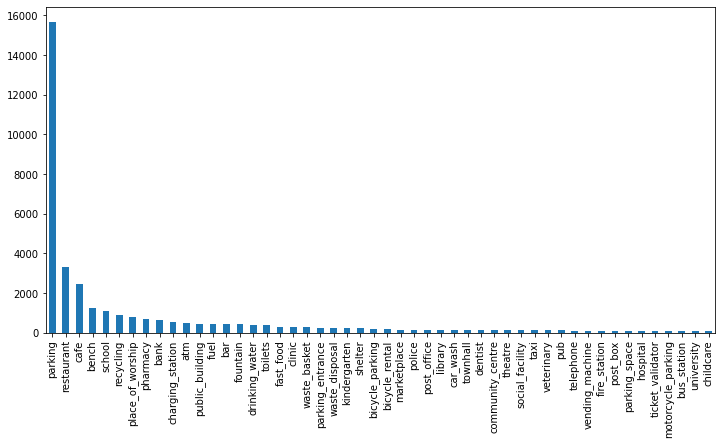

In [7]:
#types of amenities in Lisbon
s_amenities.sort_values(ascending=False)[:50] \
  .plot(kind='bar', figsize=(12, 6));

# OSMnx Street Network Analysis

## Load Region

In [8]:
%%time
G = ox.graph_from_place('Lisbon', simplify=True)

CPU times: user 46 s, sys: 600 ms, total: 46.6 s
Wall time: 46.7 s


In [9]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [10]:
%%time
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

CPU times: user 6.67 s, sys: 9.92 ms, total: 6.68 s
Wall time: 6.67 s


In [11]:
print(f"Num nodes: {len(nodes)}, num edges: {len(edges)}")

Num nodes: 31311, num edges: 77038


In [12]:
nodes.head(5)

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
21270959,38.757318,-9.165944,3,NaN,NaN,POINT (-9.16594 38.75732)
21270962,38.758035,-9.161733,3,NaN,NaN,POINT (-9.16173 38.75804)
21270969,38.763211,-9.136542,3,NaN,NaN,POINT (-9.13654 38.76321)
21272087,38.747959,-9.188383,3,NaN,NaN,POINT (-9.18838 38.74796)
21272088,38.747807,-9.188400,3,NaN,NaN,POINT (-9.18840 38.74781)


In [13]:
edges.head(2)

,,,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,junction,bridge,ref,access,width,tunnel,service,landuse
u,v,key,,,,,,,,,,,,,,,,
21270959,413210796,0,22278074,True,3,Avenida General Norton de Matos/2ª Circular,trunk,80,44.832,"LINESTRING (-9.16594 38.75732, -9.16646 38.75730)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21270962,21270959,0,"[22278074, 396719604]",True,"[3, 4]",Avenida General Norton de Matos/2ª Circular,trunk,80,375.295,"LINESTRING (-9.16173 38.75804, -9.16283 38.757...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
%%time
G_projected = ox.project_graph(G)

CPU times: user 16.7 s, sys: 0 ns, total: 16.7 s
Wall time: 16.7 s


In [16]:
%%time
nodes_proj, edges_proj = ox.graph_to_gdfs(
    G_projected, nodes=True, edges=True)

CPU times: user 4.08 s, sys: 19.3 ms, total: 4.1 s
Wall time: 4.1 s


In [17]:
edges_proj.crs

<Projected CRS: +proj=utm +zone=29 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 29N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

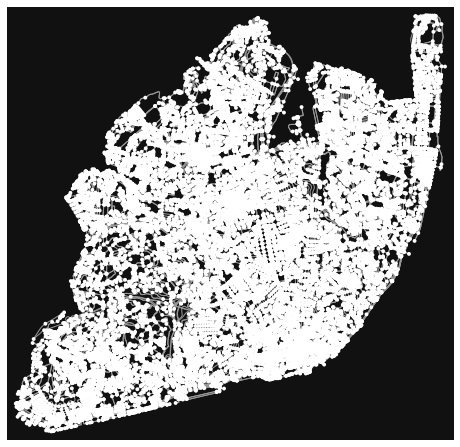

In [18]:
fig, ax = ox.plot_graph(G_projected)

## Calculate Basic Stats

In [19]:
%%time
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
# Show output
convex_hull

# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(G_projected, area=area)
stats

CPU times: user 8min 56s, sys: 6.13 s, total: 9min 3s
Wall time: 9min 2s


{'n': 31311,
 'm': 77038,
 'k_avg': 4.920826546581074,
 'intersection_count': 27205,
 'streets_per_node_avg': 2.951742199227109,
 'streets_per_node_counts': {0: 0,
  1: 4106,
  2: 201,
  3: 20437,
  4: 6273,
  5: 258,
  6: 34,
  7: 0,
  8: 1,
  9: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.13113602248411102,
  2: 0.006419469196129156,
  3: 0.6527099102551819,
  4: 0.2003449267030756,
  5: 0.008239915684583692,
  6: 0.0010858803615342852,
  7: 0.0,
  8: 3.1937657692184855e-05,
  9: 3.1937657692184855e-05},
 'edge_length_total': 4053217.4370000497,
 'edge_length_avg': 52.61322252654599,
 'street_length_total': 2479110.4090000037,
 'street_length_avg': 53.67898858912186,
 'street_segments_count': 46184,
 'node_density_km': 327.59281682495146,
 'intersection_density_km': 284.63359783216134,
 'edge_density_km': 42406.97893362896,
 'street_density_km': 25937.809782644075,
 'circuity_avg': 1.3644023424014901e-05,
 'self_loop_proportion': 0.004231677873257353,
 'clean_intersection_cou

## Extended Stats

%%time
extended_stats = ox.extended_stats(G_projected, ecc=True, cc=True)
series = pd.Series(extended_stats)
series

## Visualize Stats

stats_columns = [
    'avg_neighbor_degree', 
    'degree_centrality', 
    'clustering_coefficient', 
    'pagerank', 
    'eccentricity', 
    'closeness_centrality'
]

series_list = [pd.Series(extended_stats[column_name], name=column_name).sort_index()
               for column_name in stats_columns]
series_list.append(nodes_proj['geometry'].sort_index())

gdf_stats = pd.concat(series_list, axis=1)

gdf_stats = gpd.GeoDataFrame(
    gdf_stats, geometry="geometry", crs=nodes_proj.crs)
gdf_stats.head(2)

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))

for idx, column_name in enumerate(stats_columns):
    j = idx % ncols
    i = (idx - j) // ncols
    
    ax = axes[i][j]
    gdf_stats.plot(ax=ax, column=column_name, legend=True, s=6, alpha=0.8)
    ax.set_title(column_name)

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8))

for idx, column_name in enumerate(stats_columns):
    j = idx % ncols
    i = (idx - j) // ncols
    
    ax = axes[i][j]
    gdf_stats[column_name].plot(ax=ax, kind='hist', bins=100)
    ax.set_title(column_name)